# Guided Project: Analyzing NYC High School Data

For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic datasets. During some of the other lessons, we combined the following datasets into a single, clean pandas dataframe:

- SAT scores by school - SAT scores for each high school in New York City
- School attendance - Attendance information for each school in New York City
- Class size - Information on class size for each school
- AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- Graduation outcomes - The percentage of students who graduated and other outcome information
- Demographics - Demographic information for each school
- School survey - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

## 1. Introduction - Read in the Data

In [29]:
import pandas as pd
import numpy
import re


data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## 1. Introduction -  Read in the Surveys

In [30]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## 1. Introduction -  Add DBN columns

In [31]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## 1. Introduction -  Convert Columns to Numeric

In [32]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## 1. Introduction - Condense Datasets

In [33]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## 1. Introduction -  Convert AP Scores to Numeric

In [34]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## 1. Introduction -  Combine the Datasets

In [35]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## 1. Introduction - Add a School District Column for Mapping

In [36]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## 1. Introduction - Find Correlations

In [37]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


## 1. Introduction - Plotting Survey Correlations

In [38]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

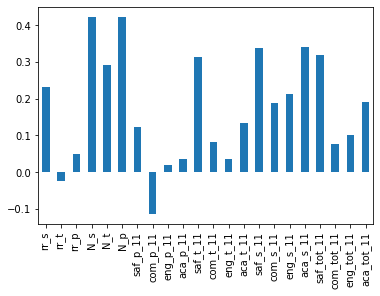

In [39]:
import matplotlib as mp
%matplotlib inline

combined.corr()['sat_score'][survey_fields].plot.bar()

Number of student respondents (N_s) has a positive correlation with the SAT scores.

Number of parent respondent (N_p) also has a strong positive relationship with the SAT Score.

Its surprising that teacher and parent response rates have no correlation with the SAT scores. 

The communication score based on parent responses has a weak negative correlation with the SAT score, which is surprising. 

Other strong positive relationship are:

Safety and Respect score based on teacher responses   saf_t 
Safety and Respect score based on student responses saf_s
Safety and Respect total score
Academic expectations score based on student responses

There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

## 2. Exploring Safety and SAT Scores

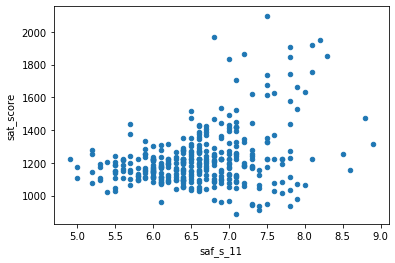

In [40]:
combined.plot.scatter(x = 'saf_s_11', y = 'sat_score')

The safety score range of 5-7, the SAT scores are between 1000 to 1400 mostly, but after score of 7.5, the SAT scores start imporving with a high positive correlation.

## Visuaising Geographical Data with Basemap

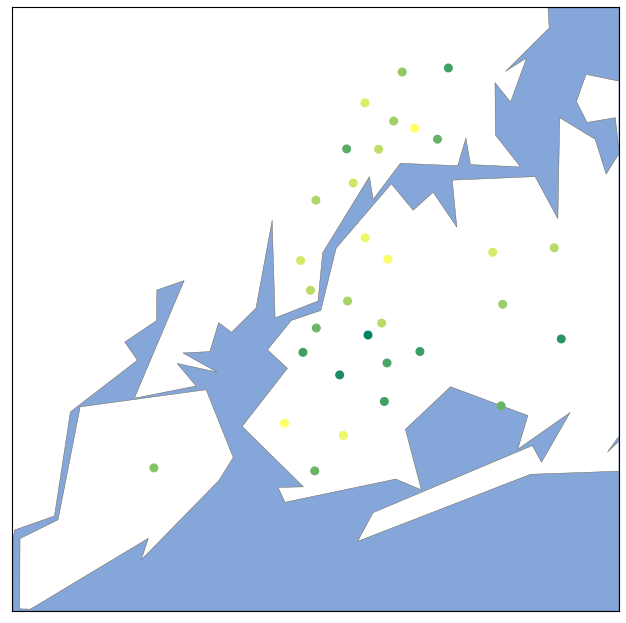

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.pyplot import figure


figure(figsize=(14, 10), dpi=80)

# districts = combined.groupby('school_dist').agg(numpy.mean)
# districts.reset_index(inplace = True)

dis_avg = combined.groupby("school_dist").agg(numpy.mean)
dis_avg.reset_index(inplace=True)

m = Basemap(  #all you need to supply are the coordinates for the four corners of the patch of map you want to zoom into. If you expand out you can get the whole world! 
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9') #filling the land with white additional to course


longitudes = dis_avg['lon'].tolist() # took a long time but make sure you use the new DF (grouped) and NOT "combined"
latitudes  = dis_avg['lat'].tolist()

m.scatter(longitudes, latitudes, s= 50, zorder = 2, latlon = True, c=dis_avg['saf_s_11'], cmap='summer')
plt.show()



Brooklyn has got a higher score for safety than queen and manhattan, upper manhattan is higfher , lower brookly is not great either. 

## 3. Exploring Race and SAT Scores

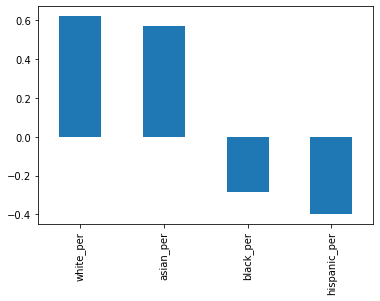

In [42]:
race_cols = ['white_per',
'asian_per',
'black_per',
'hispanic_per']


combined.corr()['sat_score'][race_cols].plot.bar()

Higher percentage of hispanic and blacks means low SAT scores, higher percentage of whites and asians means higher SAT scores. 

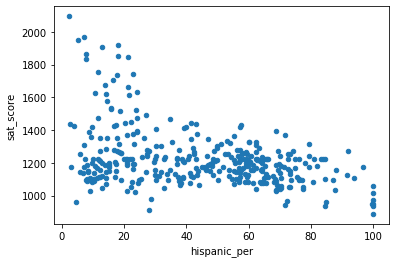

In [43]:
combined.plot.scatter(x = 'hispanic_per', y = 'sat_score')

There is a strong negative correlation with the SAT scores. but there is a big chunk of schools with low sat scores and low hispanic perchangate too. 

In [44]:
high_hispanic = combined [combined['hispanic_per']>95]
high_hispanic['school_name']


44                         Manhattan Bridges High School
82      Washington Heights Expeditionary Learning School
89     Gregorio Luperon High School for Science and M...
125                  Academy for Language and Technology
141                International School for Liberal Arts
176     Pan American International High School at Monroe
253                            Multicultural High School
286               Pan American International High School
Name: school_name, dtype: object

People are learning english so low SAT scores. Immigrants etc. 

In [45]:
low_hispanic_high_sat = combined [(combined['hispanic_per']<10) & (combined['sat_score']>1800)]

low_hispanic_high_sat['school_name']


37                                Stuyvesant High School
151                         Bronx High School of Science
187                       Brooklyn Technical High School
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object

These are top rated schools. All of them. 

# 4. Exploring Gender and SAT Scores

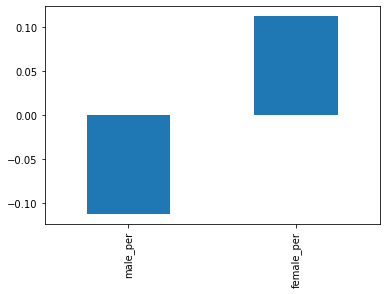

In [46]:
gender_cols = ['male_per',
'female_per']


combined.corr()['sat_score'][gender_cols].plot.bar()

The correlaion is weak, but still it is positive for girls and negative for boys.

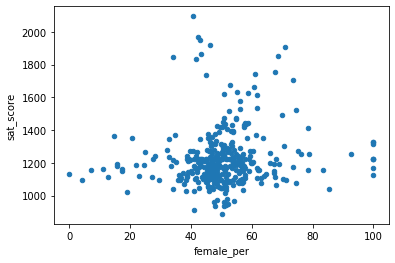

In [47]:
combined.plot.scatter(x ='female_per' , y ='sat_score' )

Not much of a strong correlation, but the highest scores are around 40% girls 

In [48]:
high_girl_SAT = combined [(combined['female_per']>60) & (combined['sat_score']>1700)]
high_girl_SAT['school_name']

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object

Selective schools with high admission standards

# 5. Exploring AP Scores vs. SAT Scores

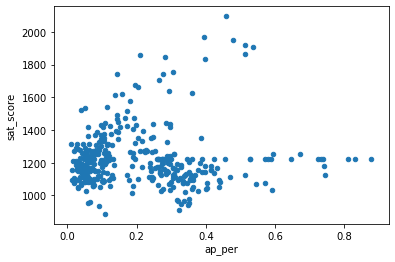

In [49]:
combined['ap_per']=combined['AP Test Takers ']/combined['total_enrollment']

combined.plot.scatter(x='ap_per', y='sat_score')


Increased Advanced Test takers does not indicate higher scores in SAT. Highest SAT scores are for around 40% AP test takers. It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.